# Transfer Learning for Binary Image Classification

In [2]:
%pip install tensorflow keras numpy pandas matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

2025-03-06 23:36:39.293877: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 23:36:39.298464: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 23:36:39.306967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741314999.326120   39224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741314999.331191   39224 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 23:36:39.352691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Dataset Preparation

In [8]:
!wget -c https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
!wget -c https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

!unzip -q validation-horse-or-human.zip -d validation-horse-or-human
!unzip -q horse-or-human.zip -d horse-or-human

# Defining the training and validation directories
train_dir = 'horse-or-human'
validation_dir = 'validation-horse-or-human'

print("Training folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(validation_dir))

--2025-03-05 00:48:00--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4001:802::201b, 2800:3f0:4001:805::201b, 2800:3f0:4001:806::201b, ...
Conectando-se a storage.googleapis.com (storage.googleapis.com)|2800:3f0:4001:802::201b|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 149574867 (143M) [application/zip]
Salvando em: “horse-or-human.zip”

horse-or-human.zip  100%[===================>] 142,65M  8,60MB/s    em 22s     

2025-03-05 00:48:28 (6,54 MB/s) - “horse-or-human.zip” salvo [149574867/149574867]

--2025-03-05 00:48:28--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolvendo storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4001:80e::201b, 2800:3f0:4001:806::201b, 2800:3f0:4001:805::201b, ...
Conectando-se a storage.googleapis.com (storage.googleapis.com)|2800:3f0:4001

### Data Preprocessing

Define Data Generators

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

Create Data Generators

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Model Setup

Load and Configure the Pre-trained Model

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

2025-03-05 00:49:46.689462: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Add Custom Layers

In [12]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

Compile the Final Model

In [13]:
model = Model(base_model.input, x)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train the Model

In [17]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


2025-03-05 00:52:53.678818: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-03-05 00:52:53.761871: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-03-05 00:52:53.943776: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46080000 exceeds 10% of free system memory.
2025-03-05 00:52:53.999971: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-03-05 00:52:54.082162: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6273 - loss: 0.6673

/home/henrique/Documentos/GitHub/dioProjects/machineLearning/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6307 - loss: 0.6627 - val_accuracy: 0.9297 - val_loss: 0.1819
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9139 - loss: 0.2486 - val_accuracy: 0.9492 - val_loss: 0.1285
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9498 - loss: 0.1634 - val_accuracy: 0.9414 - val_loss: 0.1424
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9340 - loss: 0.1651 - val_accuracy: 0.9336 - val_loss: 0.1521
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9645 - loss: 0.1215 - val_accuracy: 0.9531 - val_loss: 0.1144
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9522 - loss: 0.1260 - val_accuracy: 0.9453 - val_loss: 0.1585
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9690 - loss: 0.1064 - val_accuracy: 0.9375 - val_loss: 0.1874
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9713 - loss: 0.0929 - val_accuracy: 0.9492 - val_loss: 0.1570
Epo

### Evaluate Model Performance

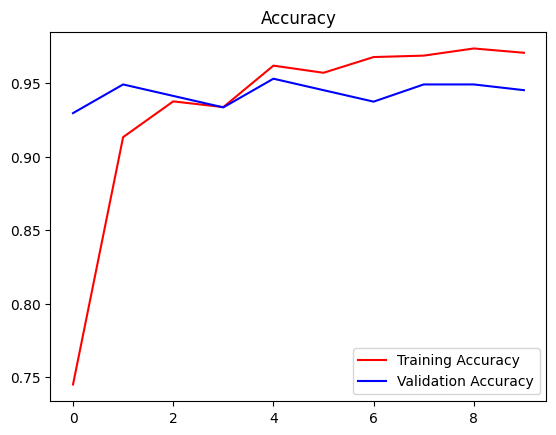

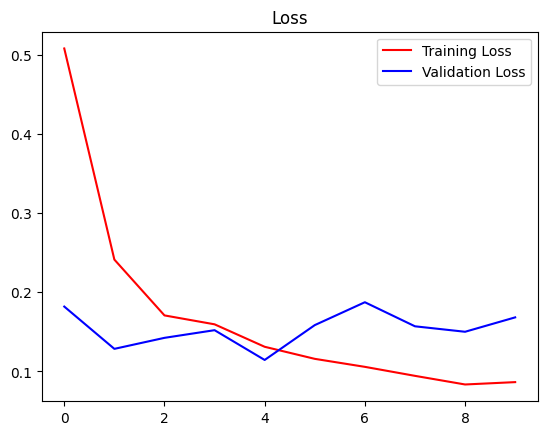

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

### Testing the Model with Custom Images

In [28]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150)) 
    img_array = image.img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0) 

    prediction = model.predict(img_array) 
    if prediction[0] > 0.5:
        print("Class: Human")
    else:
        print("Class: Horse")

predict_image('horse.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Class: Horse
